## Figures

In [1]:
import matplotlib.pyplot as plt
import matplotlib as matplt
import seaborn as sns
import pandas as pd
import os
matplt.rcParams['pdf.fonttype'] = 42
matplt.rcParams['ps.fonttype'] = 42

### Helpers

In [2]:
def get_values(data, column, value):
    indices = data[column] == value
    return data[indices]


def get_prim_values(data, backend, prim):
    df = get_values(data, "primitive", prim)
    df = get_values(df, "backend", backend)
    return df["number"].to_numpy()


def get_time_values(data, backend):
    df = get_values(data, "backend", backend)
    return df["time"].to_numpy()

### Calculate primitive utilization (LUT or DSP) for a given program

In [3]:
def calculate_util(prim, prog):
    filename = "{}.csv".format(prog)
    data = pd.read_csv(os.path.join("..", "data", "util", filename))
    data = data.sort_values(by=["length"])
    ret = get_values(data, "backend", "reticle")
    ret = get_values(ret, "primitive", "lut")
    length = []
    backend = []
    number = []
    for b in ["base", "hint", "reticle"]:
        for n in get_prim_values(data, b, prim):
            backend.append(b)
            number.append(n)
        length += list(ret["length"].to_numpy())
    res = {}
    res["backend"] = backend
    res["length"] = length
    res["number"] = number
    return pd.DataFrame.from_dict(res)

### Calculate compiler speedup for a given program

In [4]:
def compiler_speedup(prog):
    filename = "{}.csv".format(prog)
    data = pd.read_csv(os.path.join("..", "data", "compiler", filename))
    data = data.sort_values(by=["length"])
    ret = get_values(data, "backend", "reticle")
    length = []
    backend = []
    speedup = []
    for b in ["base", "hint", "reticle"]:
        new = get_time_values(data, b)
        base = get_time_values(data, "base")
        for (n0, n1) in zip(new, base):
            backend.append(b)
            speedup.append(n1 / n0)
        length += list(ret["length"].to_numpy())
    res = {}
    res["backend"] = backend
    res["length"] = length
    res["speedup"] = speedup
    return pd.DataFrame.from_dict(res)

### Calculate runtime speedup for a given program

In [5]:
def runtime_speedup(prog):
    file = "{}.csv".format(prog)
    data = pd.read_csv(os.path.join("..", "data", "runtime", file))
    data = data.sort_values(by=["length"])
    ret = get_values(data, "backend", "reticle")
    length = []
    backend = []
    speedup = []
    for b in ["base", "hint", "reticle"]:
        new = get_time_values(data, b)
        base = get_time_values(data, "base")
        for (n0, n1) in zip(new, base):
            backend.append(b)
            speedup.append(n1 / n0)
        length += list(ret["length"].to_numpy())
    res = {}
    res["backend"] = backend
    res["length"] = length
    res["speedup"] = speedup
    return pd.DataFrame.from_dict(res)

### Plot a given program

In [6]:
def plot_prog(prog):
    sns.set_theme(style="whitegrid")
    compiler = compiler_speedup(prog)
    runtime = runtime_speedup(prog)
    lut = calculate_util("lut", prog)
    dsp = calculate_util("dsp", prog)
    fig, axes = plt.subplots(1, 4, figsize=(15, 3))
    sns.set_palette(sns.color_palette("muted"))
    sns.barplot(
        ax=axes[0], x="length", y="speedup", hue="backend", data=compiler
    )
    sns.barplot(
        ax=axes[1], x="length", y="speedup", hue="backend", data=runtime
    )
    sns.barplot(ax=axes[2], x="length", y="number", hue="backend", data=lut)
    sns.barplot(ax=axes[3], x="length", y="number", hue="backend", data=dsp)
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Size")
    axes[1].set_xlabel("Size")
    axes[2].set_xlabel("Size")
    axes[3].set_xlabel("Size")
    axes[0].set_ylabel("Compiler speedup (log)")
    axes[1].set_ylabel("Run-time speedup")
    axes[2].set_ylabel("LUTs used")
    axes[3].set_ylabel("DSPs used")
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()
    if prog == "tdot":
        for i in range(4):
            axes[i].set_xticklabels(["5x3", "5x9", "5x18", "5x36"])
    new_labels = ["base", "hint", "reticle"]
    handles, _ = axes[3].get_legend_handles_labels()
    axes[3].legend(
        handles,
        new_labels,
        fontsize="10",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title="Lang",
    )
    plt.tight_layout()
    plt.savefig("{}.pdf".format(prog))

### Figure 14a (tensoradd)

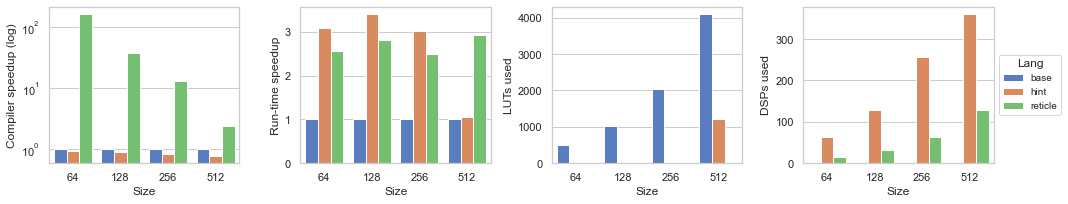

In [7]:
plot_prog("tadd")

### Figure 14b (tensordot)

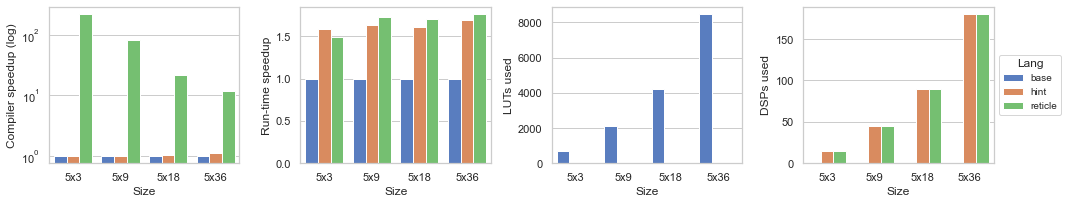

In [8]:
plot_prog("tdot")

### Figure 14c (fsm)

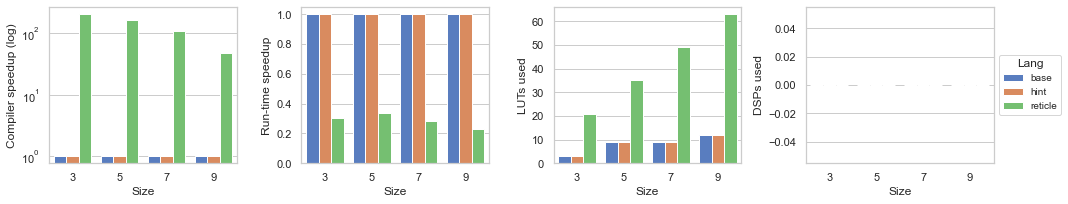

In [9]:
plot_prog("fsm")